In [56]:
import os
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.transform import resize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Dropout, Lambda
from tensorflow.keras import layers, Model
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model



(50688, 2) (654, 2)
(50, 2)
(654, 2)
<class 'numpy.ndarray'>
10 2 81
(4, 480, 640, 3) (4, 480, 640, 1)


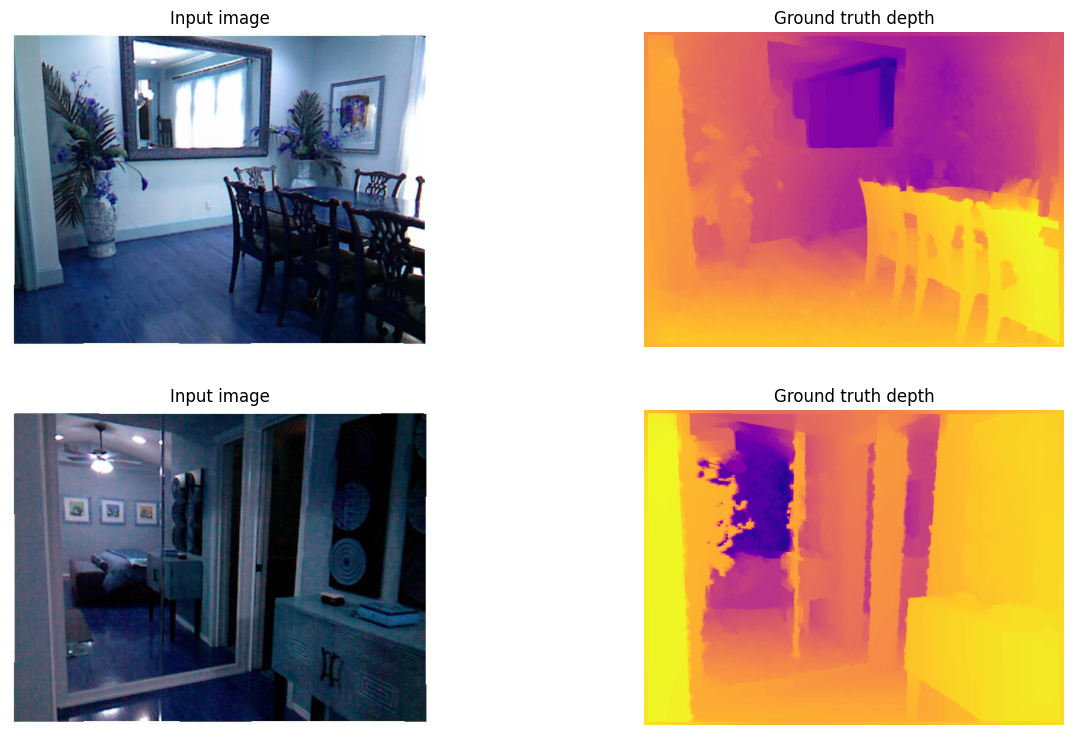

In [57]:
#Hyper params
split = 0.8
height, width = 240, 320

train_df = pd.read_csv(r'D:\New folder (2)\NYU V2\nyu_data\data\nyu2_train.csv',header=None)
test = pd.read_csv(r'D:\New folder (2)\NYU V2\nyu_data\data\nyu2_test.csv',header=None).rename(columns={0:'image', 1:'depth'})
train_df = train_df.sample(frac=1).reset_index(drop=True).rename(columns={0:'image', 1:'depth'})
base_path = r'E:/Deep Learning/MDE/NYU V2/nyu_data'
train_df['image'] = train_df['image'].map(lambda x:os.path.join(base_path,x))
train_df['depth'] = train_df['depth'].map(lambda x:os.path.join(base_path,x))
test['image'] = test['image'].map(lambda x:os.path.join(base_path,x))
test['depth'] = test['depth'].map(lambda x:os.path.join(base_path,x))

#train_df.head()
#test.head()

print(train_df.shape,test.shape)
train_df=train_df[:50]
print(train_df.shape)

train_split = int(len(train_df)*split)
train = train_df[:train_split]
validation = train_df[train_split:]
len(train), len(validation)

print(test.shape)
# train_df.head()
print(type(train_df['image'].unique()))
#dd=train_df.set_index('image')['depth'].to_dict()
# dd
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, dataframe, batch_size, shuffle=False, dim=(320, 240)):
        np.random.seed(43)
        self.df = dataframe
        self.height, self.width = dim
        self.shuffle = shuffle
        self.batch_size = batch_size
        self.ids = dataframe['image'].unique()
        self.imgtodpth = dataframe.set_index('image')['depth'].to_dict()
        self.on_epoch_end()

    def __len__(self):
        return len(self.df) // self.batch_size  #number of total batches required

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def load_data(self, indexes):
        query_imgs = [self.ids[idx] for idx in indexes]
        target_imgs = [self.imgtodpth[img] for img in query_imgs]

        processed_query_img = []
        processed_depth_img = []

        for img_path, depth_path in zip(query_imgs, target_imgs):
            # Preprocess the image
            read_img = cv2.imread(img_path)
            resized_img = cv2.resize(read_img, (640, 480)).astype(np.float32)
            scaled_img = (resized_img - resized_img.min()) / (resized_img.max() - resized_img.min())
            flip = np.random.choice([False, False])
            if flip:
                scaled_img = cv2.flip(scaled_img, 1)
            processed_query_img.append(scaled_img)

            # Preprocess the depth map
            resized_img = cv2.resize(cv2.cvtColor(cv2.imread(depth_path), cv2.COLOR_BGR2GRAY), (640, 480)).astype(np.float32)
            scaled_img = (resized_img - resized_img.min()) / (resized_img.max() - resized_img.min())
            if flip:
                scaled_img = cv2.flip(scaled_img, 1)
            scaled_img = np.expand_dims(scaled_img, axis=-1)
            processed_depth_img.append(scaled_img)

        return np.array(processed_query_img), np.array(processed_depth_img)

    def __getitem__(self, index):
        idxs = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]
        return self.load_data(idxs)
train_generator = DataGenerator(train, batch_size=4, shuffle=True, dim=(640,480))
val_generator = DataGenerator(validation, batch_size=4, shuffle=False, dim=(640,480))
test_generator = DataGenerator(test, batch_size=8, shuffle=False, dim=(640,480))
print(len(train_generator), len(val_generator), len(test_generator))
images,depths = next(iter(val_generator))
print(images.shape, depths.shape)

cmap = "plasma_r"
plt.figure(figsize=(15,9))
for i in range(0,4,2):
    image = images[i]
    depth = depths[i].squeeze(-1)
    plt.subplot(221+i)
    plt.axis('off')
    plt.imshow(image)
    plt.title('Input image')
    plt.subplot(222+i)
    plt.axis('off')
    plt.imshow(depth,cmap=plt.get_cmap(cmap))
    plt.title('Ground truth depth')

In [58]:
# Check input shape of data generators
print("Train input shape:", train_generator[0][0].shape)
print("Validation input shape:", val_generator[0][0].shape)
print("Test input shape:", test_generator[0][0].shape)

# Check output shape of data generators
print("Train output shape:", train_generator[0][1].shape)
print("Validation output shape:", val_generator[0][1].shape)
print("Test output shape:", test_generator[0][1].shape)


Train input shape: (4, 480, 640, 3)
Validation input shape: (4, 480, 640, 3)
Test input shape: (8, 480, 640, 3)
Train output shape: (4, 480, 640, 1)
Validation output shape: (4, 480, 640, 1)
Test output shape: (8, 480, 640, 1)


In [59]:
class DownscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding, name='downscale_conv1')
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding, name='downscale_conv2')
        self.preluA = layers.PReLU(alpha_initializer=tf.initializers.Constant(0.2), name='downscale_prelu1')
        self.preluB = layers.PReLU(alpha_initializer=tf.initializers.Constant(0.2), name='downscale_prelu2')
        self.bn2a = tf.keras.layers.BatchNormalization(name='downscale_bn1')
        self.bn2b = tf.keras.layers.BatchNormalization(name='downscale_bn2')
        self.pool = layers.MaxPool2D((2, 2), (2, 2), name='downscale_pool')

    def call(self, input_tensor):
        d = self.convA(input_tensor)
        x = self.bn2a(d)
        x = self.preluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.preluB(x)

        x += d
        p = self.pool(x)
        return x, p
    
class UpscaleBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.us = layers.Conv2DTranspose(filters, kernel_size=(2, 2), strides=(2, 2), padding="same", name='upscale_conv_transpose')
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding, name='upscale_conv1')
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding, name='upscale_conv2')
        self.preluA = tf.keras.layers.PReLU(alpha_initializer=tf.initializers.Constant(0.2), name='upscale_prelu1')
        self.preluB = tf.keras.layers.PReLU(alpha_initializer=tf.initializers.Constant(0.2), name='upscale_prelu2')
        self.bn2a = tf.keras.layers.BatchNormalization(name='upscale_bn1')
        self.bn2b = tf.keras.layers.BatchNormalization(name='upscale_bn2')
        self.conc = layers.Concatenate(name='upscale_concatenate')

    def call(self, x, skip):
        x = self.us(x)
        concat = self.conc([x, skip])
        x = self.convA(concat)
        x = self.bn2a(x)
        x = self.preluA(x)

        x = self.convB(x)
        x = self.bn2b(x)
        x = self.preluB(x)

        return x
    
class BottleNeckBlock(layers.Layer):
    def __init__(
        self, filters, kernel_size=(3, 3), padding="same", strides=1, **kwargs
    ):
        super().__init__(**kwargs)
        self.convA = layers.Conv2D(filters, kernel_size, strides, padding, name='bottle_neck_conv1')
        self.convB = layers.Conv2D(filters, kernel_size, strides, padding, name='bottle_neck_conv2')
        self.preluA = tf.keras.layers.PReLU(alpha_initializer=tf.initializers.Constant(0.2), name='bottle_neck_prelu1')
        self.preluB = tf.keras.layers.PReLU(alpha_initializer=tf.initializers.Constant(0.2), name='bottle_neck_prelu2')

    def call(self, x):
        x = self.convA(x)
        x = self.preluA(x)
        x = self.convB(x)
        x = self.preluB(x)
        return x
    

@tf.keras.utils.register_keras_serializable()
class DepthEstimationModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.ssim_loss_weight = 0.85
        self.l1_loss_weight = 0.1
        self.edge_loss_weight = 0.9
        self.loss_metric = tf.keras.metrics.Mean(name="loss")
        f = [16, 32, 64, 128, 256]
        self.downscale_blocks = [
            DownscaleBlock(f[0]),
            DownscaleBlock(f[1]),
            DownscaleBlock(f[2]),
            DownscaleBlock(f[3]),
        ]
        self.bottle_neck_block = BottleNeckBlock(f[4])
        self.upscale_blocks = [
            UpscaleBlock(f[3]),
            UpscaleBlock(f[2]),
            UpscaleBlock(f[1]),
            UpscaleBlock(f[0]),
        ]
        self.conv_layer = layers.Conv2D(1, (1, 1), padding="same", activation="tanh", name='final_conv_layer')

    @classmethod
    def from_config(cls, config):
        return cls()  # You can modify this to handle config parameters if needed
    def calculate_loss(self, target, pred):
        # Edges
        dy_true, dx_true = tf.image.image_gradients(target)
        dy_pred, dx_pred = tf.image.image_gradients(pred)
        weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))
        weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))

        # Depth smoothness
        smoothness_x = dx_pred * weights_x
        smoothness_y = dy_pred * weights_y

        depth_smoothness_loss = tf.reduce_mean(abs(smoothness_x)) + tf.reduce_mean(
            abs(smoothness_y)
        )

        # Structural similarity (SSIM) index
        ssim_loss = tf.reduce_mean(
            1
            - tf.image.ssim(
                target, pred, max_val=width, filter_size=7, k1=0.01 ** 2, k2=0.03 ** 2
            )
        )
        # Point-wise depth
        l1_loss = tf.reduce_mean(tf.abs(target - pred))

        loss = (
            (self.ssim_loss_weight * ssim_loss)
            + (self.l1_loss_weight * l1_loss)
            + (self.edge_loss_weight * depth_smoothness_loss)
        )

        return loss

    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch_data):
        input, target = batch_data
        with tf.GradientTape() as tape:
            pred = self(input, training=True)
            loss = self.calculate_loss(target, pred)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def test_step(self, batch_data):
        input, target = batch_data

        pred = self(input, training=False)
        loss = self.calculate_loss(target, pred)

        self.loss_metric.update_state(loss)
        return {
            "loss": self.loss_metric.result(),
        }

    def call(self, x):
        c1, p1 = self.downscale_blocks[0](x)
        c2, p2 = self.downscale_blocks[1](p1)
        c3, p3 = self.downscale_blocks[2](p2)
        c4, p4 = self.downscale_blocks[3](p3)

        bn = self.bottle_neck_block(p4)

        u1 = self.upscale_blocks[0](bn, c4)
        u2 = self.upscale_blocks[1](u1, c3)
        u3 = self.upscale_blocks[2](u2, c2)
        u4 = self.upscale_blocks[3](u3, c1)

        return self.conv_layer(u4)


In [60]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.0002,
    amsgrad=False,
)
model = DepthEstimationModel()
# Compile the model
model.compile(optimizer)
model.load_weights('model_new.weights.h5')
# # Define the path where you want to save the model
# model_checkpoint_path = r"D:\New folder (2)"

# # Ensure the directory exists
# os.makedirs(model_checkpoint_path, exist_ok=True)
# # Save the model before training
# model.save(os.path.join(model_checkpoint_path, "depth_estimation_model_initial.h5"))

# # Define the ModelCheckpoint callback to save the model during training
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath=os.path.join(model_checkpoint_path, "depth_estimation_model_best.h5"),
#     save_best_only=True,  # Save only the best model based on the validation loss
#     monitor="val_loss",   # Monitor validation loss
#     mode="min",           # Minimize validation loss
#     verbose=1             # Show progress
# )


# Define hyperparameters
epochs = 1

# Train the model
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator
)

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 194 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 56s 3s/step - loss: 0.7007 - val_loss: 0.3305


In [61]:
model.save_weights('model_new.weights.h5')

In [62]:
model.load_weights('model_new.weights.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


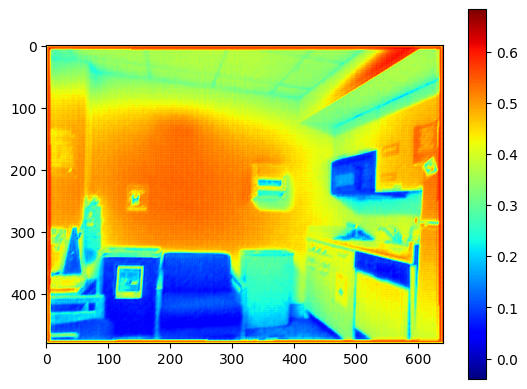

In [63]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the input image
input_image = cv2.imread(r"C:\Users\User\OneDrive\Desktop\Flask\00000_colors.png")  # Add the file extension (.jpg, .png, etc.)
# Check if the image is loaded successfully
if input_image is None:
    print("Error: Unable to load the image.")
else:
    # Convert BGR to RGB
    input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)

    # Define preprocess_input function
    def preprocess_input(image):
        # Convert to float32
        image = image.astype('float32')
        # Normalize pixel values to the range [0, 1]
        image /= 255.0
        # You may perform additional preprocessing steps here as needed
        return image

    # Preprocess the input image
    input_image = preprocess_input(input_image)

    # Make predictions using the loaded model
    depth_map = model.predict(np.expand_dims(input_image, axis=0))

    # Visualize the predicted depth map
    plt.imshow(depth_map[0, ..., 0], cmap='jet')
    plt.colorbar()
    plt.show()


In [65]:
model.save('unique_model_name.h5')


ValueError: Unable to synchronously create dataset (name already exists)